# GLM with CNN-Encoded QPESUMS Data

We are goign to use CNN-encoded QPESUMS for further ML modeling.

In [114]:
import numpy as np
import pandas as pd
import os, logging

xpath = 'D:\\worksapce/qpetw/data/qpesums_encoded'
ypath = 'D:\\data/precipitation.tpe/466880.csv'


logging.basicConfig(level=logging.INFO)

# Load input/output data for model
def loadIOTab(srcx, srcy, dropna=False):
    import pandas as pd
    import os
    # Read raw input and output
    #logging.info("Reading input X from: "+ srcx)
    logging.info("Reading input X from: "+ srcx)
    xfiles = []
    for root, dirs, files in os.walk(srcx): 
        for fn in files: 
            if fn.endswith('.npy'): 
                 xfiles.append({'date':fn.replace('.enc.npy',''), 'xuri':os.path.join(root, fn)})
    xfiles = pd.DataFrame(xfiles)
    logging.info("... read input size: "+str(xfiles.shape))
    #logging.info("Reading output Y from: "+ srcy)
    logging.info("Reading output Y from: "+ srcy)
    yraw = pd.read_csv(srcy, encoding='utf-8')
    yraw['date'] = yraw['date'].apply(str)
    logging.info("... read output size: "+str(yraw.shape))
    # Create complete IO-data
    logging.info("Pairing X-Y and splitting training/testing data.")
    iotab = pd.merge(yraw, xfiles, on='date', sort=True)
    logging.info("... data size after merging: "+str(iotab.shape))
    # Dro NA if specified
    if dropna:
        logging.info('Dropping records with NA')
        iotab = iotab.dropna()
        logging.info("... data size after dropping-NAs: "+str(iotab.shape))
    # Done
    return(iotab)


def evaluate_binary(yt, yp, stid=None, ythresh=30.):
    from sklearn.metrics import confusion_matrix
    ytb = (yt>=ythresh)*1
    ypb = (yp>=ythresh)*1
    # Derive metrics
    output = {'id':stid}
    TN, FP, FN, TP = confusion_matrix(ytb, ypb).ravel()
    output['true_positive'] = np.round(TP,2)
    output['false_positive'] = np.round(FP,2)
    output['false_negative'] = np.round(FN,2)
    output['true_negative'] = np.round(TN,2)
    output['sensitivity'] = np.round(TP/(TP+FN),2)
    output['specificity'] = np.round(TN/(FP+TN),2)
    output['prevalence'] = np.round((TP+FN)/(FN+TP+FP+TN),8)
    output['ppv'] = np.round(TP/(TP+FP),4)
    output['npv'] = np.round(TN/(TN+FN),4)
    output['fpr'] = np.round(FP/(FP+TN),4)
    output['fnr'] = np.round(FN/(FN+TP),4)
    output['fdr'] = np.round(FP/(FP+TP),4)
    output['FOR'] = np.round(FN/(TN+FN),4)
    output['accuracy'] = np.round((TP+TN)/(FN+TP+FP+TN),4)
    output['F1'] = np.round(2*TP/(2*TP+FP+FN),4)
    output['MCC'] = np.round((TP*TN-FP*FN)/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)),4)
    output['informedness'] = np.round(output['sensitivity'] + output['specificity'] - 1,4)
    output['markedness'] = np.round(output['ppv'] + output['npv'] -1,4)
    return(output)


In [2]:
# Scan for input/output
iotab = loadIOTab(xpath, ypath)
iotab = iotab.loc[:,['date','t1hr','xuri']].dropna()
iotab.head()

INFO:root:Reading input X from: D:\worksapce/qpetw/data/qpesums_encoded
INFO:root:... read input size: (34402, 2)
INFO:root:Reading output Y from: D:\data/precipitation.tpe/466880.csv
INFO:root:... read output size: (35064, 9)
INFO:root:Pairing X-Y and splitting training/testing data.
INFO:root:... data size after merging: (32953, 10)


,date,t1hr,xuri
3,2013010112,1.5,D:\worksapce/qpetw/data/qpesums_encoded\201301...
4,2013010113,1.0,D:\worksapce/qpetw/data/qpesums_encoded\201301...
5,2013010114,1.0,D:\worksapce/qpetw/data/qpesums_encoded\201301...
6,2013010115,0.5,D:\worksapce/qpetw/data/qpesums_encoded\201301...
7,2013010116,2.0,D:\worksapce/qpetw/data/qpesums_encoded\201301...


## Load Input and Output Data


In [3]:
y = iotab['t1hr']
x=[]
for i in range(iotab.shape[0]):
    x.append(np.load(iotab['xuri'].iloc[i]).flatten())

x = np.array(x)
print('Data dimension of Y:')
print(y.shape)
print('Data dimension of X:')
print(x.shape)

Data dimension of Y:
(30321,)
Data dimension of X:
(30321, 64)


## Simple Linear Regression

In [4]:
import statsmodels.api as sm

# Fit the classifier
xi = sm.add_constant(x)
glm = sm.OLS(y, xi, missing='drop')
glm_results = glm.fit()

print(glm_results.summary())

                            OLS Regression Results                            
Dep. Variable:                   t1hr   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     221.9
Date:                Sat, 21 Dec 2019   Prob (F-statistic):               0.00
Time:                        14:15:35   Log-Likelihood:                -57793.
No. Observations:               30321   AIC:                         1.157e+05
Df Residuals:                   30256   BIC:                         1.163e+05
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.6975      0.275     -9.803      0.0

## Training / Testing Split

Let's try several different ways to split data.

### Before and After 2016-01-01

In [102]:
size_before_2015 = sum(iotab['date'].astype(int)<=2015010101)
print('Data index before 2015')
print(size_before_2015)
size_before_2016 = sum(iotab['date'].astype(int)<=2016010101)
print('Data index before 2016')
print(size_before_2016)

y_train = (y[:size_before_2015]>=30.)*1
x_train = x[:size_before_2015,:]

y_test = (y[size_before_2015:]>=30.)*1
x_test = x[size_before_2015:,:]

Data index before 2015
15313
Data index before 2016
23064


In [103]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import confusion_matrix

cls = linear_model.LogisticRegression(class_weight='balanced', solver='lbfgs', max_iter=1000, C=0.1)
cls.fit(x_train, y_train)
cm_train = confusion_matrix(y_train, cls.predict(x_train))
cm_test = confusion_matrix(y_test, cls.predict(x_test))

print(cm_train)

print(cm_test)

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


[[15165   137]
 [    0    11]]
[[14818   174]
 [    4    12]]


In [104]:
evaluate_binary(y_test, cls.predict(x_test), stid='46688', ythresh=1)

{'id': '46688',
 'true_positive': 12,
 'false_positive': 174,
 'false_negative': 4,
 'true_negative': 14818,
 'sensitivity': 0.75,
 'specificity': 0.99,
 'prevalence': 0.0010661,
 'ppv': 0.0645,
 'npv': 0.9997,
 'fpr': 0.0116,
 'fnr': 0.25,
 'fdr': 0.9355,
 'FOR': 0.0003,
 'accuracy': 0.9881,
 'F1': 0.1188,
 'MCC': 0.2178,
 'informedness': 0.74,
 'markedness': 0.0642}

The GLM with strong regularization (C=0.1) seems to work good enough considering **hit-rate (sensitivity)**. Then let's try SVM.


## Support Vector Machine



In [110]:
from sklearn.svm import SVC

clf = SVC(C=0.5, kernel='poly', degree=4, gamma='auto', coef0=0.0, class_weight='balanced')
clf.fit(x_train, y_train)

cm_train = confusion_matrix(y_train, clf.predict(x_train))
cm_test = confusion_matrix(y_test, clf.predict(x_test))
print(cm_train)
print(cm_test)
evaluate_binary(y_test, clf.predict(x_test), stid='46688', ythresh=1)

[[15289    13]
 [    0    11]]
[[14966    26]
 [   13     3]]


{'id': '46688',
 'true_positive': 3,
 'false_positive': 26,
 'false_negative': 13,
 'true_negative': 14966,
 'sensitivity': 0.19,
 'specificity': 1.0,
 'prevalence': 0.0010661,
 'ppv': 0.1034,
 'npv': 0.9991,
 'fpr': 0.0017,
 'fnr': 0.8125,
 'fdr': 0.8966,
 'FOR': 0.0009,
 'accuracy': 0.9974,
 'F1': 0.1333,
 'MCC': 0.138,
 'informedness': 0.19,
 'markedness': 0.1025}

As shown above, GLM provide good hit-rate with very high false alarm, SVM seems better overall but if we aim to have high hit-rate, GLM might be a better choice.

## From Classification to Regression


In [150]:
def y_to_log(y):
    ''' Convert the y to log(y+1). '''
    ylog = np.log(y+1).astype(np.float32)
    return(ylog)

def log_to_y(y):
    ''' Convert the predicted y in log-scale back to original scale. '''
    yori = (np.exp(y.flatten())-1.0).astype(np.float32)
    yori[yori<0.5] = 0.                          # Set the minimal values to 0.
    return(yori)

# Function to give report
def evaluate_regression(y_true, y_pred, verbose=0):
    import sklearn.metrics as metrics
    # Calculate measures
    results = {}
    results['y_true_mean'] = y_true.mean()
    results['y_true_var'] = y_true.var()
    results['y_pred_mean'] = y_pred.mean()
    results['y_pred_var'] = y_pred.var()
    results['rmse'] = np.sqrt(metrics.mean_squared_error(y_true,y_pred))
    if y_pred.var()<=10e-8:
        results['corr'] = 0
    else:
        results['corr'] = np.corrcoef(y_true,y_pred)[0,1]
    # Print results if verbose > 0
    if verbose>0:
        if verbose>1:
            print('Mean of y_true: ' + str(results['y_true_mean']))
            print('Variance of y_true: ' + str(results['y_true_var']))
            print('Mean of y_pred: ' + str(results['y_pred_mean']))
            print('Variance of y_pred: ' + str(results['y_pred_var']))
        print('RMSE: ' + str(results['rmse']))
        print('Corr: ' + str(results['corr']))
    # Return results
    return(results)


def plot_regression(y_true, y_pred, verbose=0):
    import matplotlib.pyplot as plt
    # Show time series
    plt.subplot(2,1,1)
    plt.plot(y_true, label='true')
    plt.plot(y_pred, '--r', label='pred')
    plt.title('Time series')
    plt.legend()
    #
    plt.subplot(2,1,2)
    plt.scatter(y_pred, y_true)
    plt.title('Predictions vs Truth')
    plt.tight_layout()
    return(plt)

In [112]:
y_train = y[:size_before_2016]
x_train = x[:size_before_2016,:]

y_test = y[size_before_2016:]
x_test = x[size_before_2016:,:]

print("Training Data dimesnion:" + str(x_train.shape))
print("Testing Data dimesnion:" + str(x_test.shape))

Training Data dimesnion:(23064, 64)
Testing Data dimesnion:(7257, 64)


DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


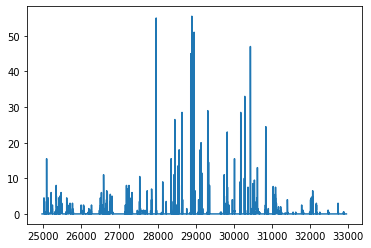

In [116]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(y_test)
plt.show()

## [Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)



DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


Training Data
{'y_true_mean': 0.2918964620187306, 'y_true_var': 3.6394317932960427, 'y_pred_mean': 0.09805756, 'y_pred_var': 0.30881575, 'rmse': 1.6520303911737257, 'corr': 0.5925993475709903}


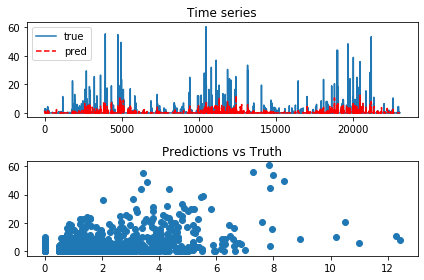


Testing Data
{'y_true_mean': 0.36455835744798126, 'y_true_var': 4.694253639682646, 'y_pred_mean': 0.1448298, 'y_pred_var': 0.56976724, 'rmse': 2.002857317685555, 'corr': 0.39754274707414045}


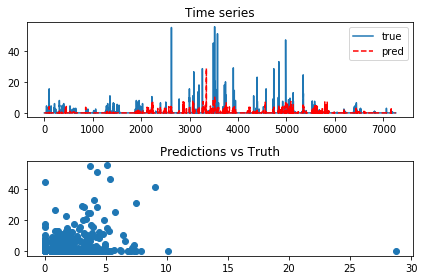

In [159]:
from sklearn import linear_model

reg = linear_model.LinearRegression(fit_intercept=True, normalize=True, copy_X=True, n_jobs=4)
reg.fit(x_train, y_to_log(y_train))
yp_train = reg.predict(x_train)
yp_test = reg.predict(x_test)

%matplotlib inline
import matplotlib.pyplot as plt

print('Training Data')
evtrain = evaluate_regression(y_train, log_to_y(yp_train))
print(evtrain)
plt = plot_regression(y_train.reset_index(drop=True), log_to_y(yp_train))
plt.show()

print('')
print('Testing Data')
evtest = evaluate_regression(y_test, log_to_y(yp_test))
print(evtest)
plt = plot_regression(y_test.reset_index(drop=True), log_to_y(yp_test))
plt.show()

## [Bayesian Ridge Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html)

BayesianRidge estimates a probabilistic model of the regression problem as described above. The prior for the coefficient  is given by a spherical Gaussian:

$p(\omega|\lambda) = N(\omega|0,\lambda^{-1}I_p)$

The priors over $\alpha$ and $\lambda$ are chosen to be gamma distributions, the conjugate prior for the precision of the Gaussian. The resulting model is called *Bayesian Ridge Regression*, and is similar to the classical Ridge.

The parameters $\omega$, $\alpha$ and $\lambda$ are estimated jointly during the fit of the model, the regularization parameters  and  being estimated by maximizing the *log marginal likelihood*. The scikit-learn implementation is based on the algorithm described in Appendix A of (Tipping, 2001) where the update of the parameters $\alpha$ and $\lambda$ is done as suggested in (MacKay, 1992). The initial value of the maximization procedure can be set with the hyperparameters `alpha_init` and `lambda_init`.

There are four more hyperparameters, $\alpha_1$, $\alpha_2$, $\lambda_1$, and  $\lambda_2$ of the gamma prior distributions over $\alpha$ and $\lambda$. These are usually chosen to be non-informative. By default $\alpha_1 = \alpha_2 = \lambda_1 = \lambda_2 = 10^{-6}$.

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


Training Data
{'y_true_mean': 0.2918964620187306, 'y_true_var': 3.6394317932960427, 'y_pred_mean': 0.09711034, 'y_pred_var': 0.29199508, 'rmse': 1.6644881902625805, 'corr': 0.5814088899164627}


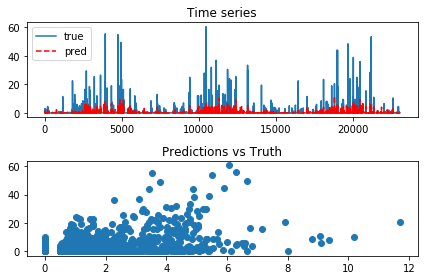


Testing Data
{'y_true_mean': 0.36455835744798126, 'y_true_var': 4.694253639682646, 'y_pred_mean': 0.14120126, 'y_pred_var': 0.49525183, 'rmse': 2.000409887667, 'corr': 0.4057055683790869}


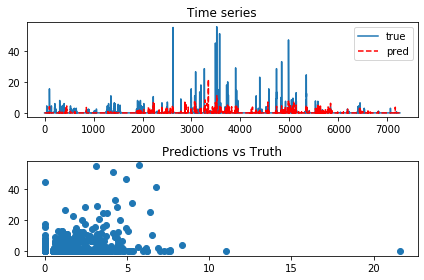

In [158]:
from sklearn import linear_model

reg = linear_model.BayesianRidge(normalize=False)
reg.fit(x_train, y_to_log(y_train))
yp_train = reg.predict(x_train)
yp_test = reg.predict(x_test)


%matplotlib inline
import matplotlib.pyplot as plt

print('Training Data')
evtrain = evaluate_regression(y_train, log_to_y(yp_train))
print(evtrain)
plt = plot_regression(y_train.reset_index(drop=True), log_to_y(yp_train))
plt.show()

print('')
print('Testing Data')
evtest = evaluate_regression(y_test, log_to_y(yp_test))
print(evtest)
plt = plot_regression(y_test.reset_index(drop=True), log_to_y(yp_test))
plt.show()

## [Support Vector Regression](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)

The method of Support Vector Classification can be extended to solve regression problems. This method is called Support Vector Regression.

The model produced by support vector classification (as described above) depends only on a subset of the training data, because the cost function for building the model does not care about training points that lie beyond the margin. Analogously, the model produced by Support Vector Regression depends only on a subset of the training data, because the cost function for building the model ignores any training data close to the model prediction.

There are three different implementations of Support Vector Regression: SVR, NuSVR and LinearSVR. LinearSVR provides a faster implementation than SVR but only considers linear kernels, while NuSVR implements a slightly different formulation than SVR and LinearSVR. See Implementation details for further details.

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


Training Data
{'y_true_mean': 0.2918964620187306, 'y_true_var': 3.6394317932960427, 'y_pred_mean': 0.06050183, 'y_pred_var': 0.20756556, 'rmse': 1.713396662696036, 'corr': 0.5549539694574913}


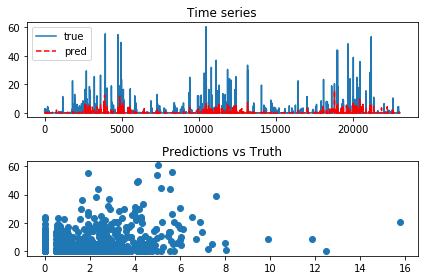


Testing Data
{'y_true_mean': 0.36455835744798126, 'y_true_var': 4.694253639682646, 'y_pred_mean': 0.10103249, 'y_pred_var': 0.4774871, 'rmse': 2.0034865264061876, 'corr': 0.4096681922230313}


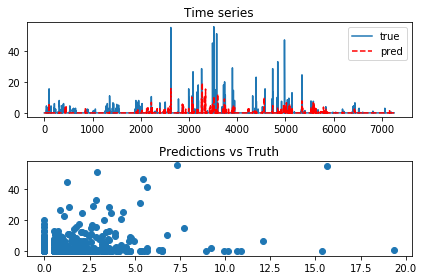

In [189]:
from sklearn import svm

reg = svm.SVR(kernel='poly', degree=2, gamma='scale', coef0=0.0, tol=0.001, C=0.05, epsilon=0.25)
reg.fit(x_train, y_to_log(y_train))
yp_train = reg.predict(x_train)
yp_test = reg.predict(x_test)


%matplotlib inline
import matplotlib.pyplot as plt

print('Training Data')
evtrain = evaluate_regression(y_train, log_to_y(yp_train))
print(evtrain)
plt = plot_regression(y_train.reset_index(drop=True), log_to_y(yp_train))
plt.show()

print('')
print('Testing Data')
evtest = evaluate_regression(y_test, log_to_y(yp_test))
print(evtest)
plt = plot_regression(y_test.reset_index(drop=True), log_to_y(yp_test))
plt.show()